# Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.fft import fft, fftfreq, ifft


import warnings
warnings.filterwarnings("ignore")

In [2]:
import random
random.seed(42)

In [3]:
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../data_modules/')
sys.path.append('../../transforms/')
sys.path.append('../../TFC_Configs/')

from config_files.TFC_Configs import *
from transforms.tfc_augmentations import *
from transforms.tfc_utils import *
from data_modules.uci import *

In [4]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 22,
    'axes.linewidth': 2,
    'axes.titlesize': 24,
    'axes.edgecolor': 'black',
    'axes.labelsize': 24,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'font.family': 'Times New Roman',
    'legend.fontsize': 16,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})

# Overview of The Method


This notebook will detail step-by-step the TF-C pretraining model used in the manuscript *Self-Supervised Contrastive Pre-Training For Time Series via Time-Frequency Consistency*. 


TF-C is a novel pre-training approach for learning generalizable features that can be transferred across different time-series datasets. The following illustration provides an overview of the idea behind and the broad applicability of TF-C. The idea is shown in **(a)**: given a time series sample, time-based and frequency-based embeddings are made close to each other in a latent time-frequency space. The application scenarios are shown in **(b)**: leveraging TF-C in time series, we can generalize a pre-train models to diverse scenarios such as gesture recognition, fault detection, and seizure analysis.


<p align="center">
    <img src="../../images/tf_c_fig1.png" width="1000" align="center">
</p>

In a large pre-training time series dataset. TF-C means the time-based representation and the frequency-based representation, which are learned from the same time series sample, are closer to each other in a joint time-frequency space, and farther apart if the representations are associated with different time series samples. By modeling the TF-C, which is a characteristic unique to time series, the developed model can capture the underlying common pattern in time series and further empower knowledge transfer across different time series datasets.

<p align="center">
    <img src="../../images/tf_c_fig2.png" width="1000" align="center">
</p>

# Loading the Data

In [5]:
uci_data_module = UCIDataModule(root_data_dir='../../data/uci/preprocessed/',
                           batch_size=32,
                           flatten=False,
                           target_column='class',
                           training_mode='Whatever',
                           transform=False) # We do not have a transformer class implemented yet

train_uci_dl = uci_data_module.train_dataloader()

In [6]:
loader_iter = iter(train_uci_dl)
first_batch = next(iter(train_uci_dl))

In [7]:
df, target = first_batch

In [8]:
target

tensor([3, 0, 1, 0, 4, 5, 5, 1, 3, 5, 5, 2, 2, 5, 0, 5, 5, 2, 3, 2, 4, 3, 2, 4,
        2, 4, 3, 3, 4, 4, 5, 4])

In [9]:
print("Dataframe Shape:", df.shape)
print("Target Shape:", target.shape)

Dataframe Shape: torch.Size([32, 6, 60])
Target Shape: torch.Size([32])


If you want to have a dataset with unique classes, use the code below

In [10]:
selected_data, unique_classes = sample_unique_classes(df, target)
print("Filtered Dataframe Shape:", selected_data.shape)
print("Unique Classes:", unique_classes)

Filtered Dataframe Shape: torch.Size([6, 6, 60])
Unique Classes: tensor([0, 1, 2, 3, 4, 5])


We filter the dataset to help with the visualization of what the augmentations does to the time series

# 1.1 Augmenting the Time Series 

For a given input time series sample $(x_i)$, we generate an augmentation set $(X^T_i)$ through a time-based augmentation bank $(B_T: x_i \rightarrow X^T_i)$. 

Each element $(\tilde{x}^T_i \in X^T_i)$ is augmented from $(x_i)$ based on the temporal characteristics. Here, the time-based augmentation bank includes well-established methods in contrastive learning

1. Jitterin: helps with robustness to small random fluctuations or noise
2. Scaling: helps recognize patterns, independently from a scaling factor
3. Masking: We make some parts of the time series equal to 0. Helps with robustness to data gaps
4. Neighborhood segmentation or permutation: robustness to losing temporal ordering or variations in the sequence

- `Although the paper stated that time-shifts was implemented, the github could showed masking in its place!`.

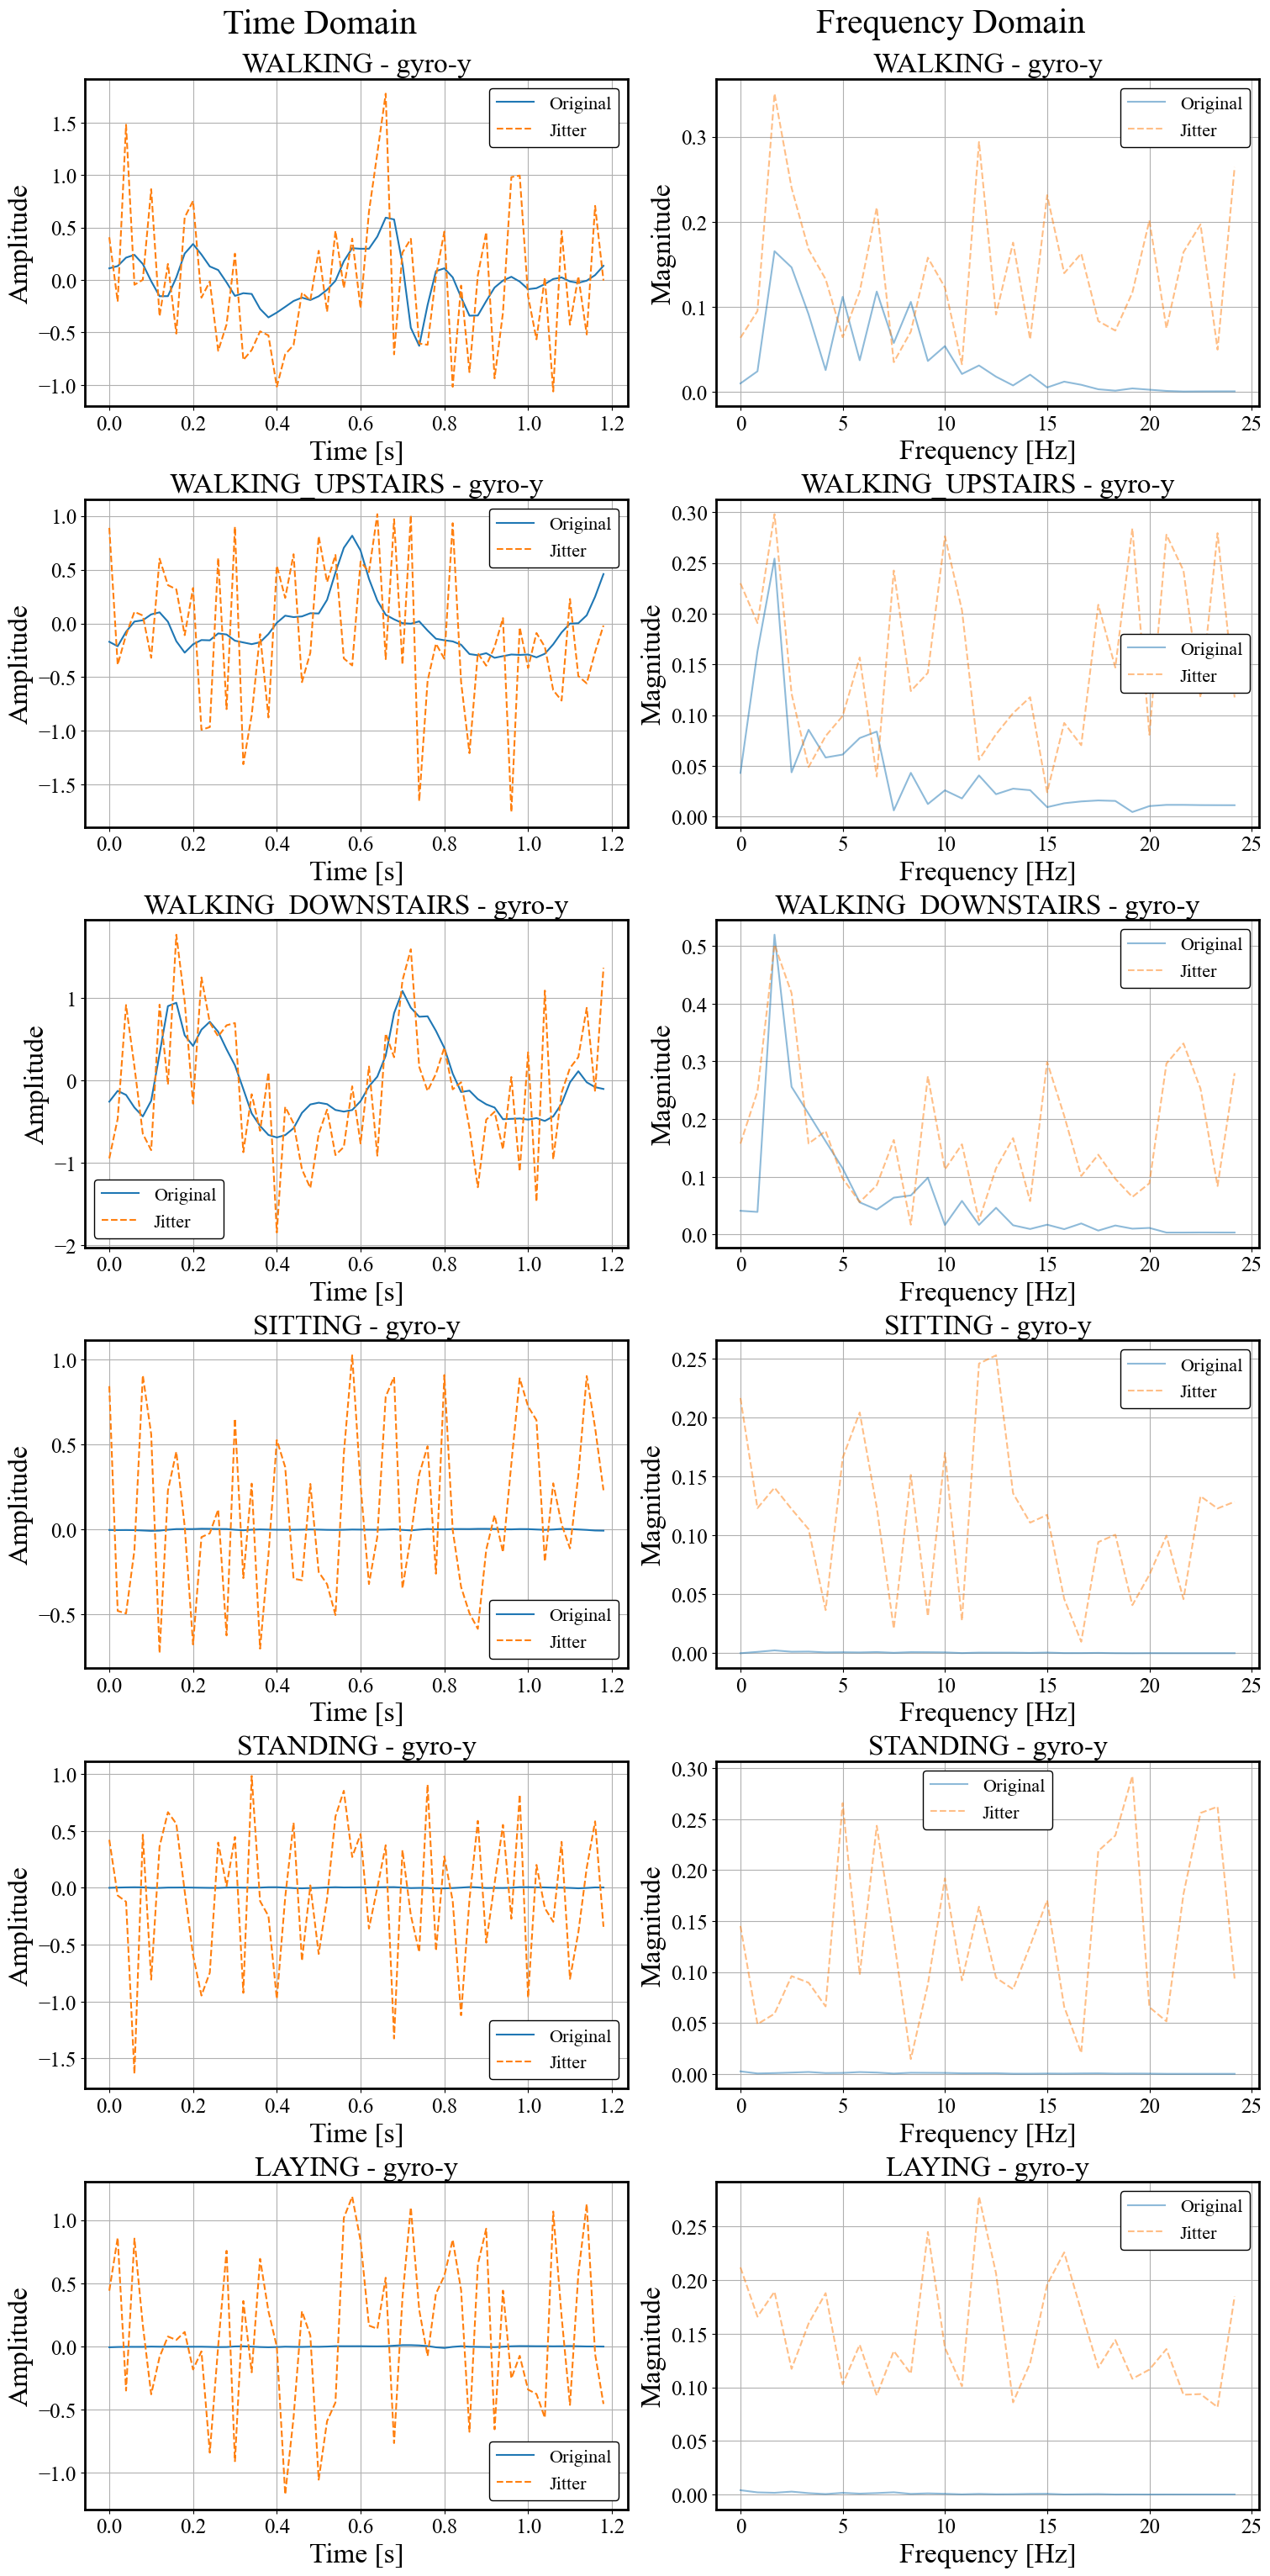

In [11]:
aug_time_and_plot_time_and_frequency_domain(data = selected_data, 
                               unique_classes=[1,2,3,4,5,6],
                               sensors = ['gyro-y'],
                               operation='jitter', # 'jitter', 'scaling', 'permutation', 'masking' 
                               )

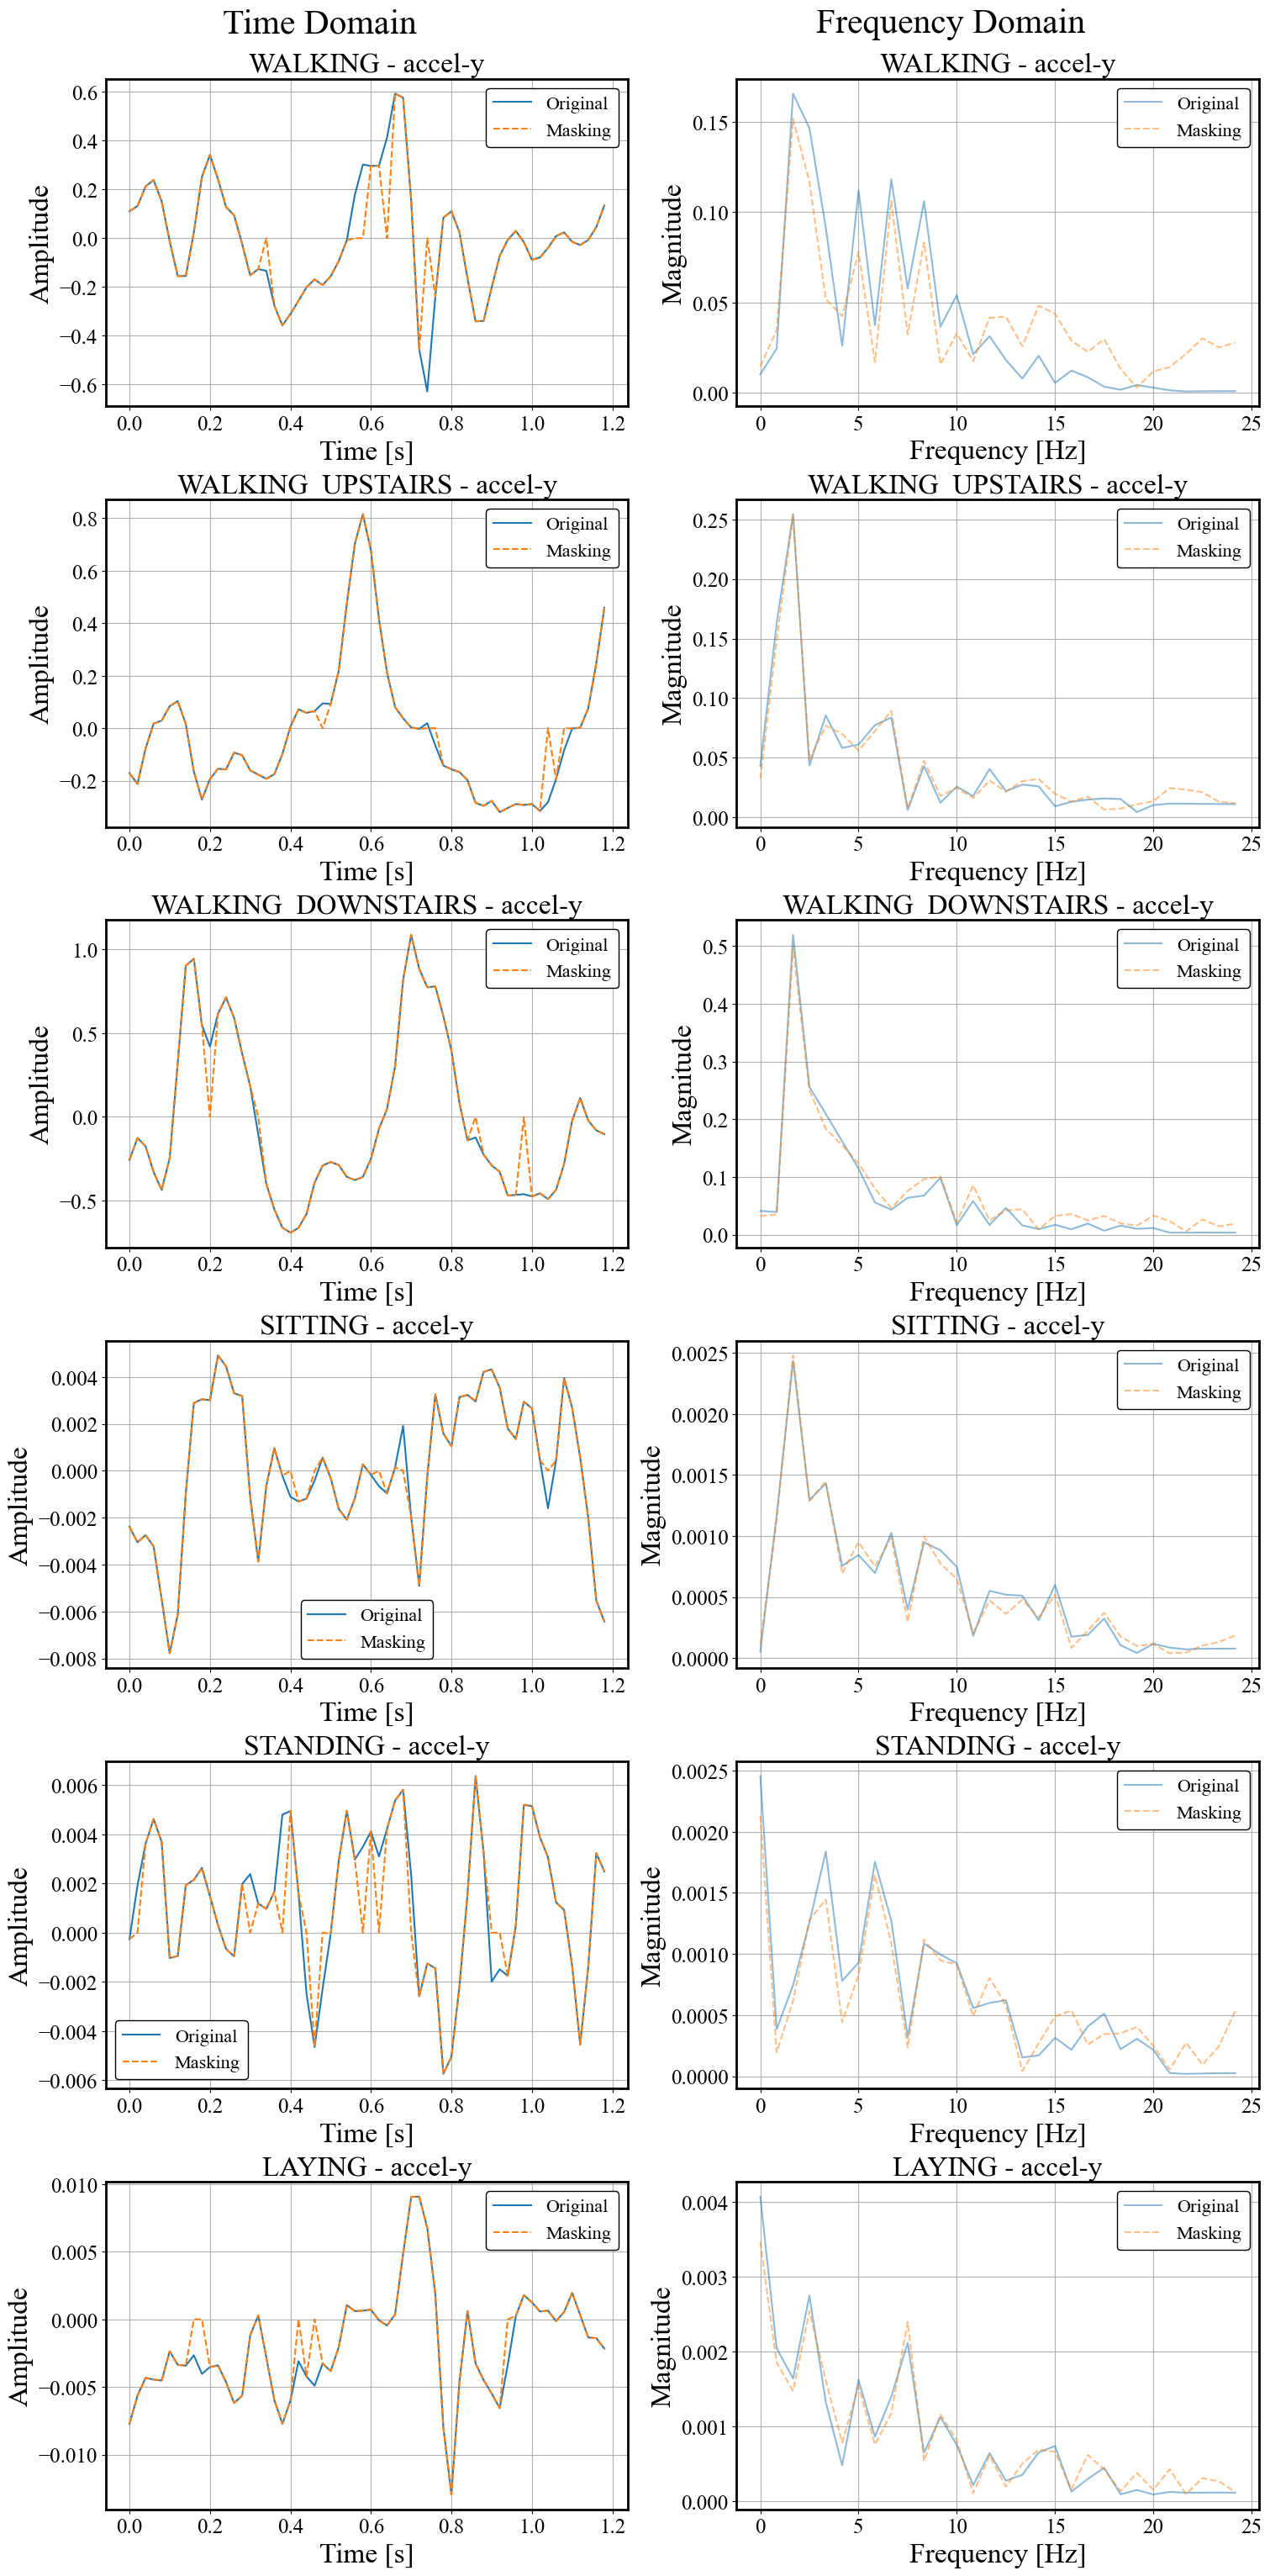

In [12]:
aug_time_and_plot_time_and_frequency_domain(data = selected_data, 
                               unique_classes=[1,2,3,4,5,6],
                               operation='masking', # 'jitter', 'scaling', 'permutation', 'masking'
                               sensors = ['accel-y']
                               )

# 1.2 Augmenting the Frequency Spectrum

Similar to section 1.1, now we simply add or remove frequency components by a small perturbation. It has to be small to avoid huge changes in the temporal pattern and be similar to the original sample. We use a small budget $(E)$ in the perturbations where $(E)$ denotes the number of frequency components we manipulate. 

The operation done are:

1. Randomly select $(E)$ frequency components and set their amplitudes to 0.
2. Randomly select $(E)$ frequency components and multiply by a scaling factor $\alpha$ so that the amplitude is $(\alpha \cdot A_m)$. 

- Note: although the scale factor $\alpha$ used to scale the amplitude is stated to be 0.5 in the work, i didn't find this in the original github page. Maybe the authors hard coded it instead of the using the np.random.uniform(0, max_amplitude * 0.1, x.shape)

- Note: All frequency augmentations are done `to the half-spectrum`

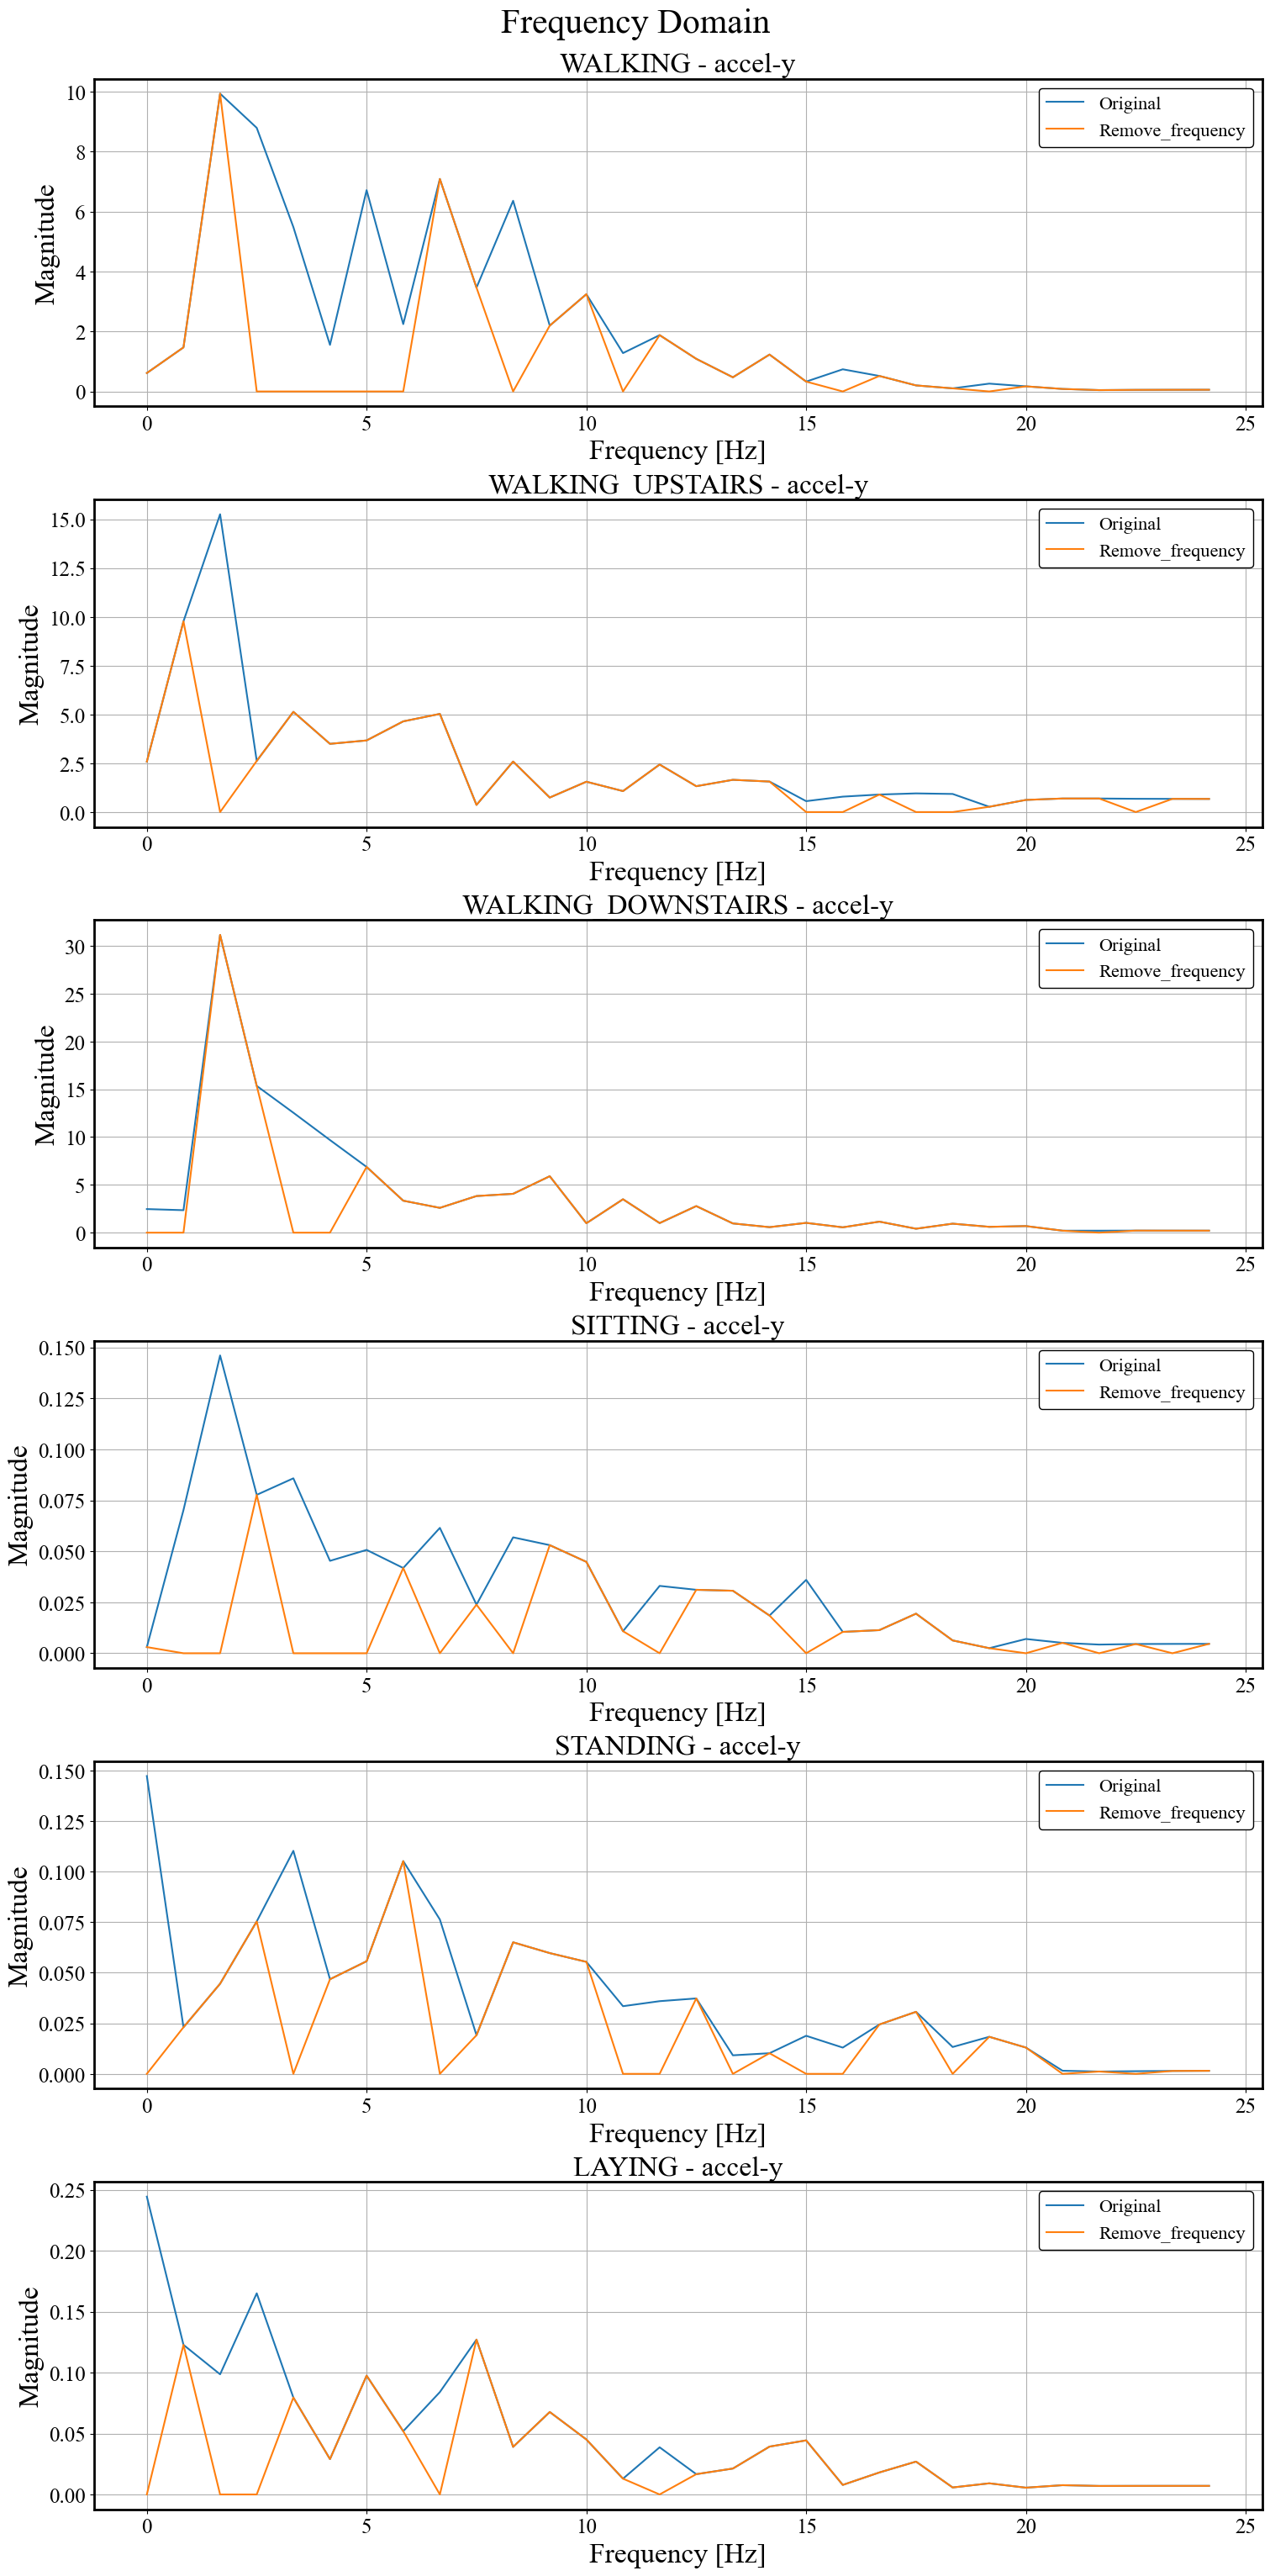

In [13]:
aug_freq_and_plot_freq_time_domain(data = selected_data, 
                               unique_classes=[1,2,3,4,5,6],
                               sensors = ['accel-y'],
                               operation='remove_frequency', # 'remove_frequency', 'add_frequency', 'both'
                               remove_ratio=0.2,
                               perturb_ratio=0.1,
                               )

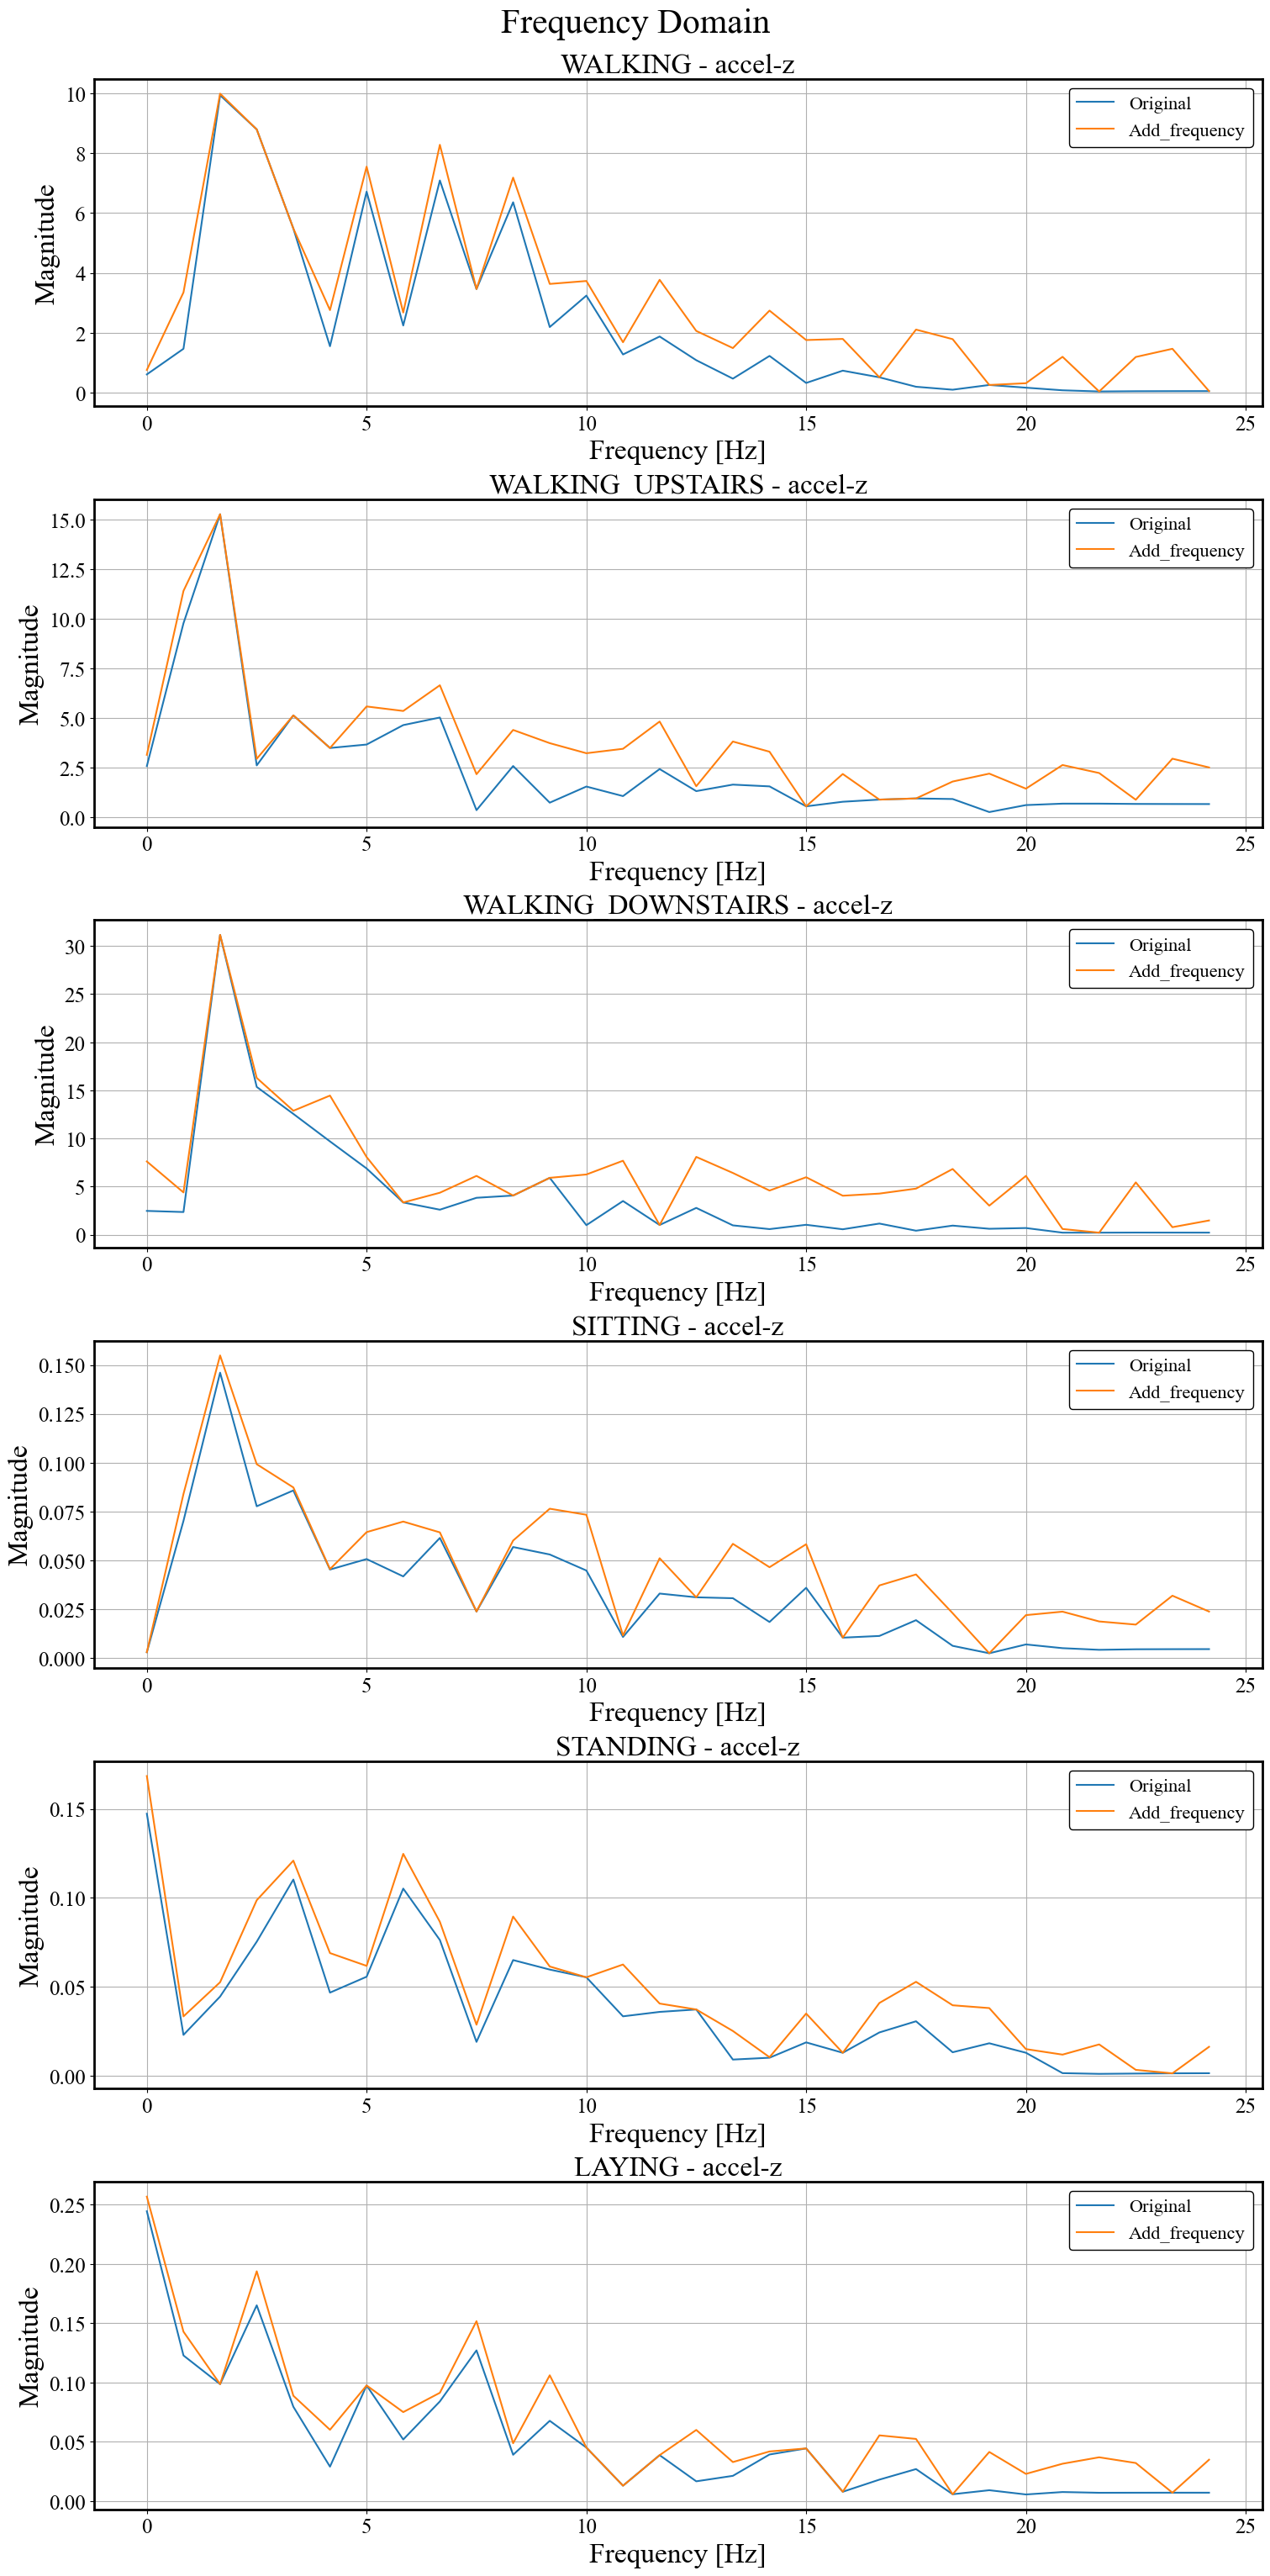

In [14]:
aug_freq_and_plot_freq_time_domain(data = selected_data, 
                               unique_classes=[1,2,3,4,5,6],
                               sensors = ['accel-z'],
                               operation='add_frequency', # 'remove_frequency', 'add_frequency', 'both'
                               remove_ratio=0.2,
                               perturb_ratio=0.2,
                               )

## Important Considerations From the Authors of the Original Paper

1. Perturbing the low-frequency or high-frequency components depends on the context of where the signal is more informative. For example, EEG is more informative for low frequencies (0.5-70 Hz) while >70 Hz is considered noise. Sensor readings my differ from this context. 

2. DO NOT PERTURB TOO MANY FREQUENCY COMPONENTS. This cause way too many changes in the original time series representation, which makes the contrastive tasks too easy! This leads to bad encoders.

3. No conclusion was drawn from either random sampling or by distribution to select which components to change in the spectrum. Just do random sampling for now

4. The authors did NOT test phase pertubation, only frequency pertubation. They state that this is future work

5. From the github, you can use the half or full spectrum. `I chose to use half spectrum amplitude`

# 2.0 Importing the Dataloader with Transformer Class

Since we use the augmentation only when training the backbone, I added a print statement for the problem we are actually working

In [15]:
global_config_file = GlobalConfigFile()
tfc_transforms = TFC_transforms(global_config_file,verbose=False)

In [16]:
uci_data_module = UCIDataModule(root_data_dir='../../data/uci/preprocessed/',
                           batch_size=32,
                           flatten=False,
                           target_column='class',
                           training_mode='Backbone',
                           transform=tfc_transforms)

train_uci_dl = uci_data_module.train_dataloader()

In [17]:
def debug_dataloader(dataloader):
    for batch in dataloader:
        time_data, time_aug_data, freq_data, freq_aug_data, labels = batch
        print(f"time_data shape: {time_data.shape}")
        print(f"time_aug_data shape: {time_aug_data.shape}")
        print(f"freq_data shape: {freq_data.shape}")
        print(f"freq_aug_data shape: {freq_aug_data.shape}")
        print(f"labels shape: {labels.shape}")
        break  # Only need to check the first batch

# In your main function or initialization
print("Debugging training dataloader")
debug_dataloader(uci_data_module.train_dataloader())

print("Debugging validation dataloader")
debug_dataloader(uci_data_module.val_dataloader())

Debugging training dataloader
time_data shape: torch.Size([32, 6, 60])
time_aug_data shape: torch.Size([32, 6, 60])
freq_data shape: torch.Size([32, 6, 60])
freq_aug_data shape: torch.Size([32, 6, 60])
labels shape: torch.Size([32])
Debugging validation dataloader
time_data shape: torch.Size([32, 6, 60])
time_aug_data shape: torch.Size([32, 6, 60])
freq_data shape: torch.Size([32, 6, 60])
freq_aug_data shape: torch.Size([32, 6, 60])
labels shape: torch.Size([32])


In [18]:
loader_iter = iter(train_uci_dl)
first_batch = next(iter(train_uci_dl))

In [19]:
original_data, time_augmented_data, norm_amplitude_spectrum, norm_amplitude_spectrum_aug, target = first_batch

In [20]:
print("Original Data Shape:", original_data.shape)
print("Time Augmented Shape:", time_augmented_data.shape)
print("FFT of Original Data Shape:", norm_amplitude_spectrum.shape)
print("Frequency Augmented Shape:", norm_amplitude_spectrum_aug.shape)
print("Target Shape:", target.shape)

Original Data Shape: torch.Size([32, 6, 60])
Time Augmented Shape: torch.Size([32, 6, 60])
FFT of Original Data Shape: torch.Size([32, 6, 60])
Frequency Augmented Shape: torch.Size([32, 6, 60])
Target Shape: torch.Size([32])


Our data loader is capable of providing both the regular time series data as the augmented views

# References:

- https://github.com/mims-harvard/TFC-pretraining/blob/main
- https://proceedings.neurips.cc/paper_files/paper/2022/file/194b8dac525581c346e30a2cebe9a369-Paper-Conference.pdf 
- https://proceedings.neurips.cc/paper_files/paper/2022/file/194b8dac525581c346e30a2cebe9a369-Supplemental-Conference.pdf

# Tests